# 迷你项目：蒙特卡洛方法

在此 notebook 中，你将自己编写很多蒙特卡洛 (MC) 算法的实现。

虽然我们提供了一些起始代码，但是你可以删掉这些提示并从头编写代码。

### 第 0 部分：探索 BlackjackEnv

请使用以下代码单元格创建 [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) 环境的实例。

In [4]:
import gym
env = gym.make('Blackjack-v0')

每个状态都是包含以下三个元素的 3 元组：
- 玩家的当前点数之和 $\in \{0, 1, \ldots, 31\}$，
- 庄家朝上的牌点数之和  $\in \{1, \ldots, 10\}$，及
- 玩家是否有能使用的王牌（`no` $=0$、`yes` $=1$）。

智能体可以执行两个潜在动作：

In [5]:
    STICK = 0 # decide to stop 
    HIT = 1 # request additional cards

通过运行以下代码单元格进行验证。

In [6]:
print(env.observation_space) # (玩家的当前点数之和, 庄家朝上的牌点数之和, 玩家是否有能使用的王牌)
print(env.action_space) #(要牌, 不要牌)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


执行以下代码单元格以按照随机策略玩二十一点。

（*代码当前会玩三次二十一点——你可以随意修改该数字，或者多次运行该单元格。该单元格旨在让你体验当智能体与环境互动时返回的输出结果。*）

In [7]:
for episode in range(3):
    # 初始化環境
    state = env.reset()
    print(state)
    while True:
        # 隨機選擇動作
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            if reward > 0:
                print('獲勝 獎勵值: ', reward)
            elif reward == 0:
                print('平手 獎勵值: ', reward)
            else:
                print('輸了 獎勵值: ', reward)
            break

(11, 10, False)
輸了 獎勵值:  -1.0
(15, 3, False)
輸了 獎勵值:  -1
(6, 3, False)
輸了 獎勵值:  -1.0


### 第 1 部分：MC 预测 - 状态值

在此部分，你将自己编写 MC 预测的实现（用于估算状态值函数）。

我们首先将研究以下策略：如果点数之和超过 18，玩家将始终停止出牌。函数  `generate_episode_from_limit` 会根据该策略抽取一个阶段。 

该函数会接收以下**输入**：
- `bj_env`：这是 OpenAI Gym 的 Blackjack 环境的实例。

它会返回以下**输出**：
- `episode`：这是一个（状态、动作、奖励）元组列表，对应的是 $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$， 其中 $T$ 是最终时间步。具体而言，`episode[i]` 返回 $(S_i, A_i, R_{i+1})$， `episode[i][0]`、`episode[i][1]`和 `episode[i][2]` 分别返回 $S_i$, $A_i$和 $R_{i+1}$。

In [8]:
def generate_episode_from_limit(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        # 如果點數超過18，就不在要牌
        action = STICK if state[0] > 18 else HIT
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

执行以下代码单元格以按照该策略玩二十一点。 

（*代码当前会玩三次二十一点——你可以随意修改该数字，或者多次运行该单元格。该单元格旨在让你熟悉  `generate_episode_from_limit` 函数的输出结果。*）

In [9]:
for i in range(3):
    print(generate_episode_from_limit(env))
    
# [((7, 2, False)(#state), 1(#action), 0（#reward）), ((14, 2, False), 1, 0), ((18, 2, False), 1, -1)]

[((6, 7, False), 1, 0), ((11, 7, False), 1, 0), ((18, 7, False), 1, -1)]
[((19, 10, False), 0, 1.0)]
[((18, 2, False), 1, -1)]


现在你已经准备好自己编写 MC 预测的实现了。你可以选择实现首次经历或所有经历 MC 预测；对于 Blackjack 环境，这两种技巧是对等的。

你的算法将有四个参数：
- `env`：这是 OpenAI Gym 环境的实例。
- `num_episodes`：这是通过智能体-环境互动生成的阶段次数。
- `generate_episode`：这是返回互动阶段的函数。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下输出结果：
- `V`：这是一个字典，其中 `V[s]` 是状态 `s` 的估算值。例如，如果代码返回以下输出结果：

[((14, 7, False), 1, -1)]

- (14, 7, False): 
    - 玩家目前點數14
    - 莊家朝上的點數7
    - 玩家沒有可以用的王牌
- 1:
    - 玩家要牌
- -1:
    - 玩家輸了

{(4, 7, False): -0.38775510204081631, (18, 6, False): -0.58434296365330851, (13, 2, False): -0.43409090909090908, (6, 7, False): -0.3783783783783784, ...

则状态 `(4, 7, False)` 的值估算为  `-0.38775510204081631`。

如果你不知道如何在 Python 中使用 `defaultdict`，建议查看[此源代码](https://www.accelebrate.com/blog/using-defaultdict-python/)。

In [10]:
from collections import defaultdict
import numpy as np
import sys

def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    # 初始化回傳值
    returns = defaultdict(list)
    
    for i_episode in range(1, num_episodes+1):
        # 列印目前進度
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # 根據策略讓agent跟env互動產生episode
        episode = generate_episode(env)
        print('episode: ', episode)
        
        # 取出此episode中所有state, action 和 reward
        states, actions, rewards = zip(*episode)
        #print('states: ', states)
        #print('actions: ', actions)
        #print('rewards: ', rewards)

        # 折扣率(先不考慮)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        #print('discounts: ', discounts)

        # 計算並記錄這個episode中每個visit
        for i, state in enumerate(states):
            returns[state].append(sum(rewards[i:]*discounts[:-(1+i)]))
            #print('returns: ', returns)

    
    # 計算state-value function的推估值
    V = {k: np.mean(v) for k, v in returns.items()}
    print('V: ', V)

    return V

使用以下单元格计算并绘制状态值函数估算值。 (_用于绘制值函数的代码来自[此源代码](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py)，并且稍作了修改。_）

要检查你的实现是否正确，应将以下图与解决方案 notebook **Monte_Carlo_Solution.ipynb** 中的对应图进行比较。

In [11]:
from plot_utils import plot_blackjack_values

# obtain the value function
V = mc_prediction_v(env, 10, generate_episode_from_limit)
#V = mc_prediction_v(env, 500000, generate_episode_from_limit)

# plot the value function
# plot_blackjack_values(V)

episode:  [((13, 7, False), 1, 0), ((15, 7, False), 1, 0), ((18, 7, False), 1, -1)]
episode:  [((12, 7, True), 1, 0), ((15, 7, True), 1, 0), ((18, 7, True), 1, 0), ((18, 7, False), 1, -1)]
episode:  [((18, 5, False), 1, -1)]
episode:  [((12, 3, False), 1, 0), ((13, 3, False), 1, -1)]
episode:  [((13, 9, False), 1, 0), ((20, 9, False), 0, 0.0)]
episode:  [((7, 5, False), 1, 0), ((18, 5, True), 1, 0), ((14, 5, False), 1, 0), ((18, 5, False), 1, -1)]
episode:  [((17, 7, False), 1, -1)]
episode:  [((19, 1, True), 0, -1.0)]
episode:  [((10, 2, False), 1, 0), ((19, 2, False), 0, 1.0)]
episode:  [((16, 2, True), 1, 0), ((12, 2, False), 1, 0), ((15, 2, False), 1, 0), ((19, 2, False), 0, 0.0)]
V:  {(13, 7, False): -1.0, (15, 7, False): -1.0, (18, 7, False): -1.0, (12, 7, True): -1.0, (15, 7, True): -1.0, (18, 7, True): -1.0, (18, 5, False): -1.0, (12, 3, False): -1.0, (13, 3, False): -1.0, (13, 9, False): 0.0, (20, 9, False): 0.0, (7, 5, False): -1.0, (18, 5, True): -1.0, (14, 5, False): -1.0, 

### 第 2 部分：MC 预测 - 动作值

在此部分，你将自己编写 MC 预测的实现（用于估算动作值函数）。  

我们首先将研究以下策略：如果点数之和超过 18，玩家将_几乎_始终停止出牌。具体而言，如果点数之和大于 18，她选择动作 `STICK` 的概率是 80%；如果点数之和不大于 18，她选择动作  `HIT` 的概率是 80%。函数 `generate_episode_from_limit_stochastic` 会根据该策略抽取一个阶段。 

该函数会接收以下**输入**：
- `bj_env`：这是 OpenAI Gym 的 Blackjack 环境的实例。

该算法会返回以下**输出结果**：
- `episode`: 这是一个（状态、动作、奖励）元组列表，对应的是 $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$， 其中 $T$ 是最终时间步。具体而言，`episode[i]` 返回 $(S_i, A_i, R_{i+1})$， `episode[i][0]`、`episode[i][1]`和 `episode[i][2]` 分别返回 $S_i$, $A_i$和 $R_{i+1}$。

In [12]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        # 如果點數超過18，選擇不要牌的機率 80%
        # 反之，選擇要牌的機率 20%
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

现在你已经准备好自己编写 MC 预测的实现了。你可以选择实现首次经历或所有经历 MC 预测；对于 Blackjack 环境，这两种技巧是对等的。

你的算法将有四个参数：
- `env`: 这是 OpenAI Gym 环境的实例。
- `num_episodes`：这是通过智能体-环境互动生成的阶段次数。
- `generate_episode`：这是返回互动阶段的函数。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下输出结果：

- `Q`：这是一个字典（一维数组），其中 `Q[s][a]` 是状态 `s` 和动作 `a` 对应的估算动作值。

In [13]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    for i_episode in range(1, num_episodes+1):
        # 列印目前進度
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # 根據策略讓agent跟env互動產生episode
        episode = generate_episode(env)
        
        # 取出此episode中所有state, action 和 reward
        states, actions, rewards = zip(*episode)
        
        # 折扣率(先不考慮)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        # loop每個state
        for i, state in enumerate(states):
            # 計算這個episode中每個state中agent決定某個action所獲得的return
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            # 計算這個episode中每個state中agent決定執行這個action的次數
            N[state][actions[i]] += 1.0
            # 獲得episode中每個state中agent決定某個action的動作估算值
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
            
    print('Q: ', Q)
     
    return Q

请使用以下单元格获取动作值函数估值 $Q$。我们还绘制了相应的状态值函数。

要检查你的实现是否正确，应将以下图与解决方案 notebook **Monte_Carlo_Solution.ipynb** 中的对应图进行比较。

In [14]:
# obtain the action-value function
Q = mc_prediction_q(env, 10, generate_episode_from_limit_stochastic)

# obtain the state-value function
#V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         #for k, v in Q.items())

# plot the state-value function
#plot_blackjack_values(V_to_plot)

Q:  defaultdict(<function mc_prediction_q.<locals>.<lambda> at 0x7f914c00e2f0>, {(21, 10, True): array([ 1.,  0.]), (13, 10, False): array([-1.,  0.]), (10, 1, False): array([ 0., -1.]), (20, 1, False): array([-1.,  0.]), (16, 9, False): array([ 0.,  0.]), (19, 9, False): array([ 1.,  0.]), (17, 9, False): array([ 1.,  0.]), (9, 10, False): array([ 0., -1.]), (19, 10, False): array([ 1.,  0.]), (8, 1, False): array([ 0., -1.]), (16, 1, False): array([ 0., -1.]), (11, 2, False): array([ 0.,  1.]), (21, 2, False): array([ 1.,  0.]), (9, 9, False): array([ 0., -1.])})


### 第 3 部分：MC 控制 - GLIE

在此部分，你将自己编写常量-$\alpha$ MC 控制的实现。

你的算法将有四个参数：

- `env`: 这是 OpenAI Gym 环境的实例。
- `num_episodes`：这是通过智能体-环境互动生成的阶段次数。
- `generate_episode`：这是返回互动阶段的函数。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下输出结果：

- `Q`：这是一个字典（一维数组），其中 `Q[s][a]` 是状态 `s` 和动作 `a` 对应的估算动作值。

- `policy`：这是一个字典，其中 `policy[s]` 会返回智能体在观察状态 `s` 之后选择的动作。

（_你可以随意定义其他函数，以帮助你整理代码。_）

In [15]:
# 根據epsilon利用epsilon-greedy policy產生episode
def generate_episode_from_Q(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    
    while True:
        # 利用epsilon-greedy policy來決定action
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()

        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
            
    return episode

# epsilon-greedy policy
def get_probs(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

# 利用episode來更新action-value function
def update_Q_GLIE(env, episode, Q, N, gamma):
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        old_N = N[state][actions[i]]
        Q[state][actions[i]] = old_Q + (sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)/(old_N+1)
        N[state][actions[i]] += 1
    
    return Q, N

In [2]:
def mc_control_GLIE(env, num_episodes, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # 設定epsilon值，隨著執行次數的增加，epsilon越來越小
        epsilon = 1.0 / ((i_episode/8000)+1)
            
        # 根據epsilon利用epsilon-greedy policy產生episode
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
            
        # 利用此episode來更新action-value function
        Q, N = update_Q_GLIE(env, episode, Q, N, gamma)
            
    # 根據最後估測的action-value function來決定最好的policy
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
        
    return policy, Q

通过以下单元格获取估算的最优策略和动作值函数。

In [17]:
# obtain the estimated optimal policy and action-value function
policy_glie, Q_glie = mc_control_GLIE(env, 1)

print('policy: ', policy_glie)
print('Q: ', Q_glie)

policy:  {(14, 9, False): 0}
Q:  defaultdict(<function mc_control_GLIE.<locals>.<lambda> at 0x7f917452cbf8>, {(14, 9, False): array([ 0., -1.])})


接着，我们将绘制相应的状态值函数。

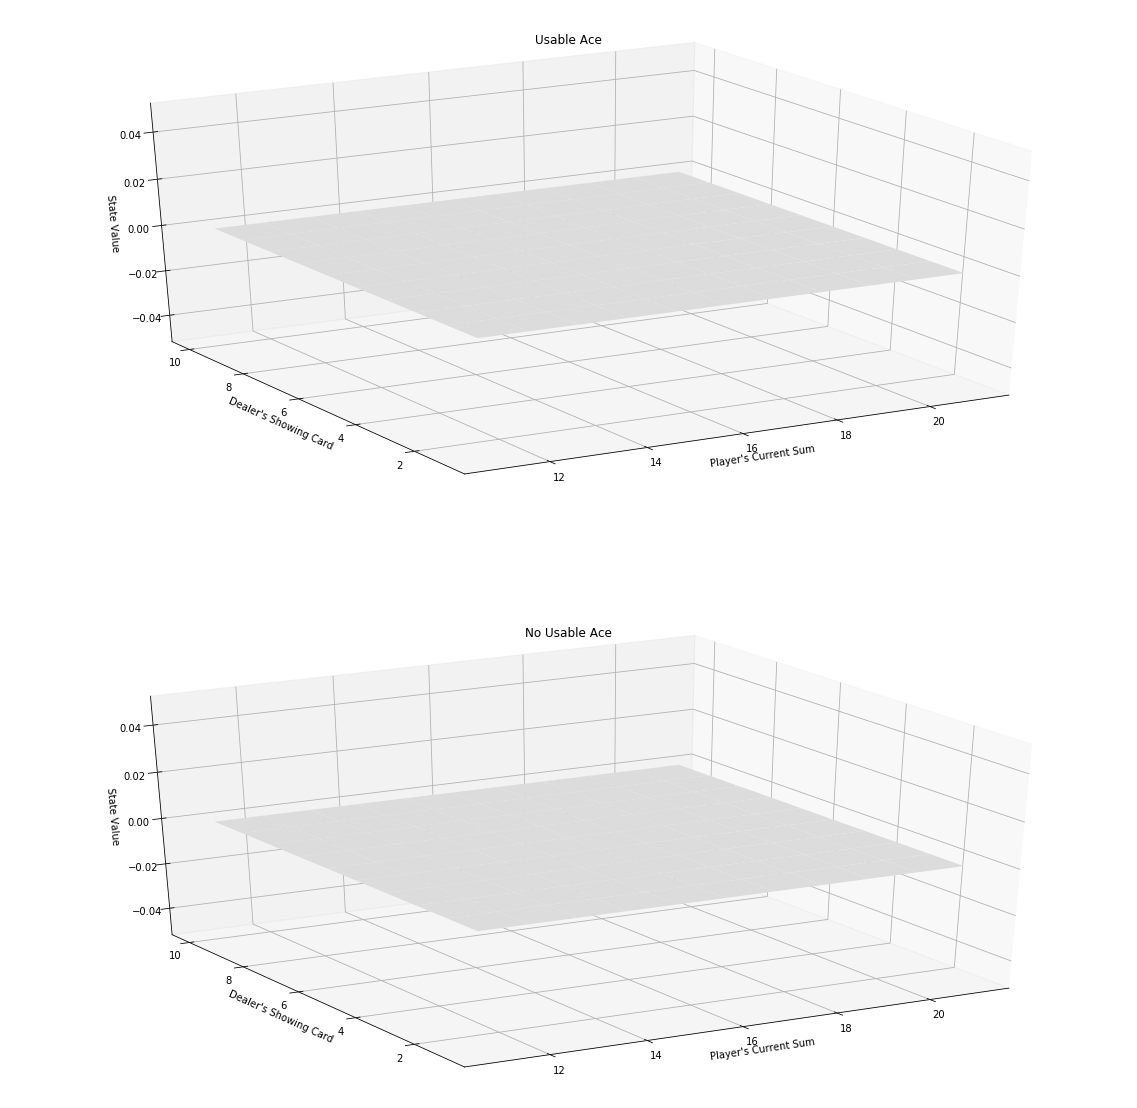

In [18]:
# obtain the state-value function
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

# plot the state-value function
plot_blackjack_values(V_glie)

最后，我们将可视化估算为最优策略的策略。

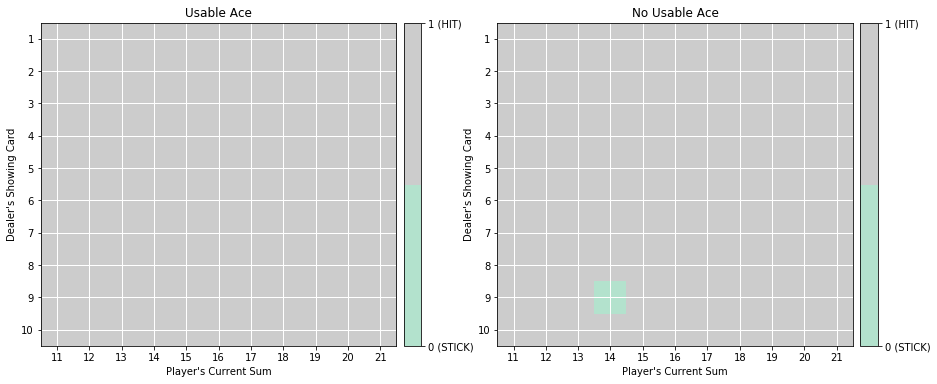

In [19]:
from plot_utils import plot_policy

# plot the policy
plot_policy(policy_glie)

**真**最优策略 $\pi_*$ 可以在该[教科书](http://go.udacity.com/rl-textbook)的第 82 页找到（下文也提供了）。请将你的最终估算值与最优策略进行比较——它们能够有多接近？如果你对算法的效果不满意，请花时间调整 $\epsilon$ 的衰减率和/或使该算法运行更多个阶段，以获得更好的结果。

![True Optimal Policy](images/optimal.png)

### 第 4 部分：MC 控制 - 常量-$\alpha$

在此部分，你将自己编写常量-$\alpha$ MC 控制的实现。  

你的算法将有三个参数：

- `env`: 这是 OpenAI Gym 环境的实例。
- `num_episodes`：这是通过智能体-环境互动生成的阶段次数。
- `generate_episode`：这是返回互动阶段的函数。
- `alpha`：这是更新步骤的步长参数。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下输出结果：

- `Q`：这是一个字典（一维数组），其中 `Q[s][a]` 是状态 `s` 和动作 `a` 对应的估算动作值。


- `policy`：这是一个字典，其中 `policy[s]` 会返回智能体在观察状态 `s` 之后选择的动作。

（_你可以随意定义其他函数，以帮助你整理代码。_）

In [21]:
def update_Q_alpha(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # 折扣率
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    # 利用alpha來更新action-value function
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [22]:
def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # 設定epsilon值，隨著執行次數的增加，epsilon越來越小
        epsilon = 1.0/((i_episode/8000)+1)
        
        # 根據epsilon利用epsilon-greedy policy產生episode
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        
        # 利用此episode來更新action-value function (使用常數alpha)
        Q = update_Q_alpha(env, episode, Q, alpha, gamma)
        
    # 根據最後估測的action-value function來決定最好的policy
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
        
    return policy, Q

通过以下单元格获得估算的最优策略和动作值函数。

In [24]:
# obtain the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 10, 0.008)

print('policy: ', policy_alpha)
print('Q: ', Q_alpha)

policy:  {(11, 8, False): 0, (11, 4, False): 1, (21, 4, False): 0, (20, 6, False): 0, (14, 6, False): 1, (12, 7, False): 1, (9, 10, False): 1, (20, 10, False): 0, (14, 3, False): 0, (8, 9, False): 0, (18, 9, False): 0, (21, 8, True): 0}
Q:  defaultdict(<function mc_control_alpha.<locals>.<lambda> at 0x7f9149dfe378>, {(11, 8, False): array([ 0.008,  0.   ]), (11, 4, False): array([ 0.   ,  0.008]), (21, 4, False): array([ 0.008,  0.   ]), (20, 6, False): array([ 0.008, -0.008]), (14, 6, False): array([ 0.   ,  0.008]), (12, 7, False): array([-0.008,  0.   ]), (9, 10, False): array([-0.008,  0.   ]), (20, 10, False): array([ 0.   , -0.008]), (14, 3, False): array([ 0.   , -0.008]), (8, 9, False): array([ 0.   , -0.008]), (18, 9, False): array([ 0.   , -0.008]), (21, 8, True): array([ 0.008,  0.   ])})


接着，我们将绘制相应的状态值函数。

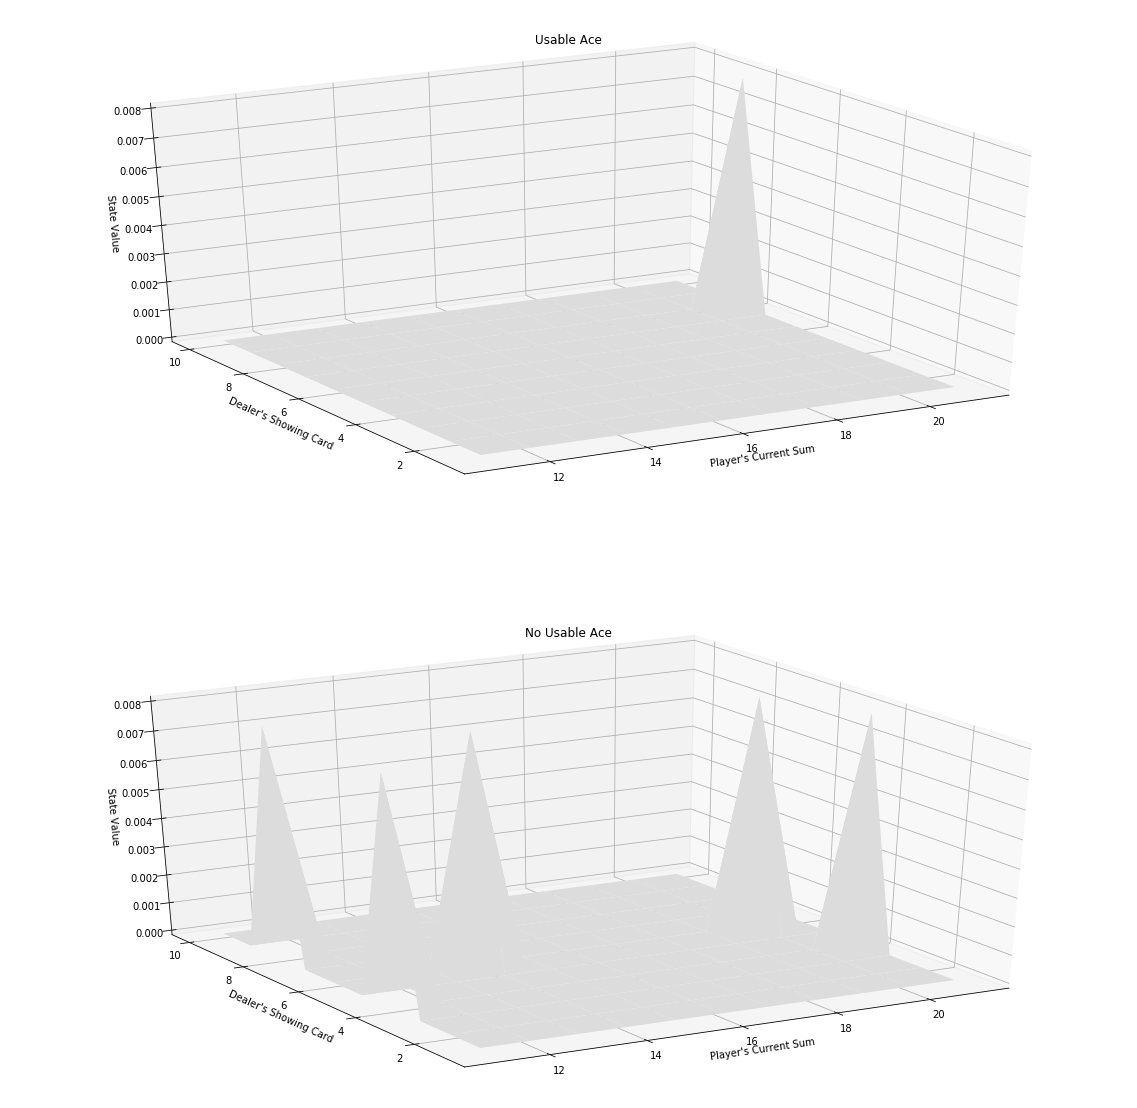

In [25]:
# obtain the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

# plot the state-value function
plot_blackjack_values(V_alpha)

最后，我们将可视化估算为最优策略的策略。

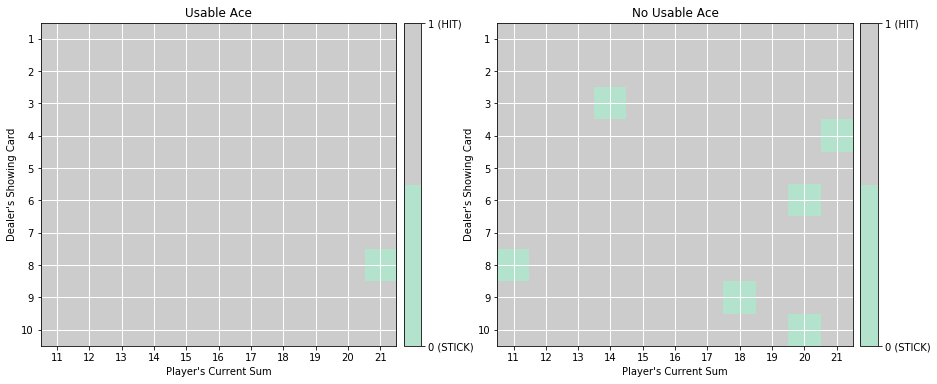

In [26]:
# plot the policy
plot_policy(policy_alpha)

**真**最优策略 $\pi_*$ 可以在该[教科书](http://go.udacity.com/rl-textbook)的第 82 页找到（下文也提供了）。请将你的最终估算值与最优策略进行比较——它们能够有多接近？如果你对算法的效果不满意，请花时间调整 $\epsilon$ 的衰减率和/或使该算法运行更多个阶段，以获得更好的结果。

![True Optimal Policy](images/optimal.png)